In [1]:
import os
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette("Dark2", n_colors=8)

from source.constants import PLOTS_PATH
os.makedirs(PLOTS_PATH, exist_ok=True)

In [2]:
x = np.linspace(0, 1, 1001)

p_model = 0.2
c_model = 0.6

# dist = stats.beta(a=5, b=5)
dist = stats.beta(a=2, b=3)

In [3]:
uncertainties = np.zeros((3, 3, 3))

def entropy(x, eps=1e-7):
    return - x * np.log2(x + eps) - (1 - x) * np.log2(1 - x + eps)

def kl_div_X1(x, eps=1e-7):
    return x * np.log2((x + eps) / c_model) + (1 - x) * np.log2((1 - x + eps) / (1 - c_model))

def kl_div_X2(x, eps=1e-7):
    return x * np.log2((x + eps) / mean) + (1 - x) * np.log2((1 - x + eps) / (1 - mean))

def kl_div_X3(ref):

    def kl_div_(x, eps=1e-7):
        return ref * np.log2((ref + eps) / (x + eps)) + (1 - ref) * np.log2((1 - ref + eps) / (1 - x + eps))

    return dist.expect(kl_div_)

mean = dist.mean()

uncertainties[0, :, 1] = entropy(p_model)
uncertainties[1, :, 1] = entropy(mean)
uncertainties[2, :, 1] = dist.expect(entropy)

uncertainties[0, 0, 2] = kl_div_X1(p_model)
uncertainties[0, 1, 2] = kl_div_X2(p_model)
uncertainties[0, 2, 2] = kl_div_X3(p_model)
uncertainties[1, 0, 2] = kl_div_X1(mean)
uncertainties[1, 1, 2] = kl_div_X2(mean)
uncertainties[1, 2, 2] = kl_div_X3(mean)
uncertainties[2, 0, 2] = dist.expect(kl_div_X1)
uncertainties[2, 1, 2] = dist.expect(kl_div_X2)
uncertainties[2, 2, 2] = uncertainties[2, 1, 2] + uncertainties[1, 2, 2]

uncertainties[..., 0] = uncertainties[..., 1] + uncertainties[..., 2]


[]

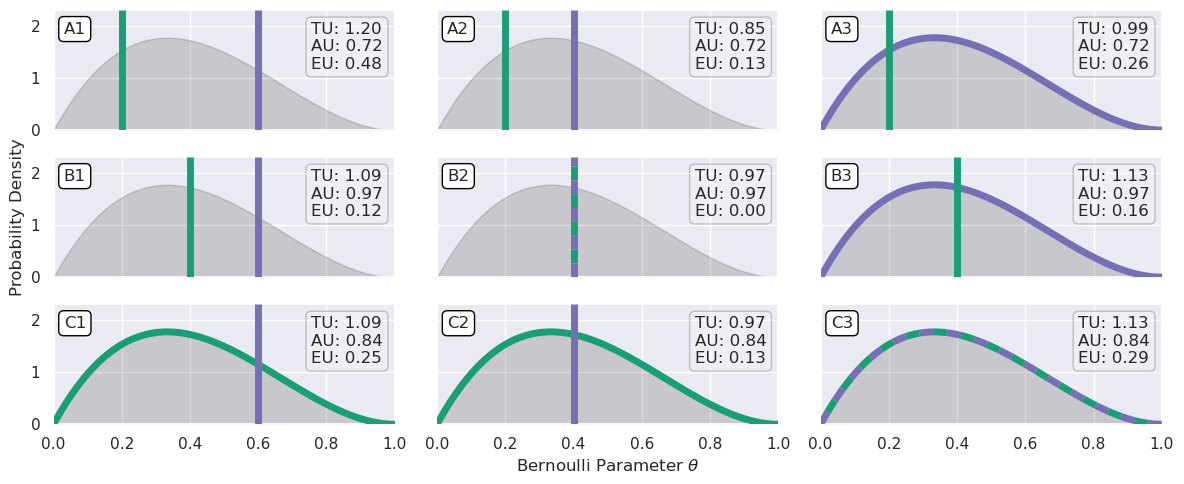

In [5]:
ls_p = (2, (2, 2))
ls_c = (0, (2, 2))
factor = 1.3
lw = 5

fig, axs = plt.subplots(3, 3, figsize=(12, 5),sharey=True, sharex=True)

for i, ax in enumerate(axs.flat):
    ax.fill_between(x, dist.pdf(x), np.zeros_like(x), x, color="black", alpha=0.15)

for i in range(3):
    axs[0, i].vlines(p_model, 0, max(dist.pdf(x)) * factor, color="C0", lw=lw, linestyle="solid", zorder=99)
    axs[1, i].vlines(dist.mean(), 0, max(dist.pdf(x)) * factor, color='C0', lw=lw, linestyle=ls_p if i == 1 else "solid", zorder=99)
    axs[2, i].plot(x, dist.pdf(x), color='C0', lw=lw, linestyle=ls_p if i == 2 else "solid", zorder=98)

    axs[i, 0].vlines(c_model, 0, max(dist.pdf(x)) * factor, color='C2', lw=lw, linestyle="solid", zorder=99)
    axs[i, 1].vlines(dist.mean(), 0, max(dist.pdf(x)) * factor, color='C2', lw=lw, linestyle=ls_c if i == 1 else "solid", zorder=99)
    axs[i, 2].plot(x, dist.pdf(x), color='C2', lw=lw, linestyle=ls_c if i == 2 else "solid", zorder=99)

for i in range(3):
    for j in range(3):
        axs[i, j].text(0.03, 1.8, f"{['A', 'B', 'C'][i]}{j+1}", ha="left", va="bottom",
                       bbox=dict(boxstyle='round, pad=0.3', edgecolor='black', facecolor='white'))
        axs[i, j].text(0.755, 1.12, '\n'.join([f"TU: {uncertainties[i, j, 0]:.2f}", 
                                          f"AU: {uncertainties[i, j, 1]:.2f}", 
                                          f"EU: {uncertainties[i, j, 2]:.2f}"]), 
                       fontsize="medium", ha="left", va='bottom', bbox=dict(boxstyle='round, pad=0.3', edgecolor='black', facecolor='white', alpha=0.2))
        axs[i, j].set_ylim(0, max(dist.pdf(x)) * factor)
        axs[i, j].set_xlim(0, 1)

axs[2, 1].set_xlabel("Bernoulli Parameter $\\theta$")
axs[1, 0].set_ylabel("Probability Density")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, "illustrative_example.pdf"))
plt.plot()